In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path
import h5py
import scipy.stats
import torch
import pandas as pd
import os
import math

import bnn_priors.plot as plot
import bnn_priors.exp_utils as exp_utils

In [2]:
def flatten(in_dict):
    out_dict = {}
    for k, v in in_dict.items():
        if isinstance(v, dict):
            v_flat = flatten(v)
            out_dict.update({k+"."+v_k: v_v for v_k, v_v in v_flat.items()})
        else:
            out_dict[k] = v
    return out_dict

In [3]:
base_log_dir = Path("/scratches/huygens/ag919/BNN-priors/logs/0_3_cifar10_sgd")

test_accs = []
test_losses = []
steps = None

for run in os.listdir(base_log_dir):
    if run in ["_sources", "jugdir", "mom1"]:
        continue
    with h5py.File(base_log_dir/run/"metrics.h5", "r", swmr=True) as f:
        if steps is None:
            steps = f["steps"][:]
        else:
            assert np.all(steps == f["steps"][:])
        test_accs.append(f["test/acc"][:])
        test_losses.append(f["test/loss"][:])

In [4]:
base_log_dir = Path("/scratches/huygens/ag919/BNN-priors/logs/0_5_lr_cifar10")

series_list = []

for run in os.listdir(base_log_dir):
    if run in ["_sources", "jugdir"]:
        continue
    with open(base_log_dir/run/"run.json") as f:
        s2 = pd.Series(flatten(json.load(f)))
    with open(base_log_dir/run/"config.json") as f:
        s1 = pd.Series(flatten(json.load(f)))
        
    s2["the_dir"] = base_log_dir/run
    series_list.append(pd.concat([s1, s2]))
        
    
df = pd.DataFrame(series_list)
full_df = df[df["status"] != "FAILED"]
full_df[["lr", "temperature", "weight_prior", "inference", "status"]]

,lr,temperature,weight_prior,inference,status
0,0.100000,0.01,gaussian,VerletSGLDReject,COMPLETED
2,0.000316,0.01,convcorrnormal,VerletSGLDReject,RUNNING
3,0.003162,0.01,gaussian,VerletSGLDReject,COMPLETED
4,0.001000,1.00,gaussian,HMCReject,COMPLETED
6,0.100000,1.00,gaussian,VerletSGLDReject,COMPLETED
7,0.003162,1.00,gaussian,HMCReject,COMPLETED
9,0.010000,1.00,gaussian,VerletSGLDReject,COMPLETED
12,0.000316,0.01,gaussian,VerletSGLDReject,COMPLETED
13,0.031623,1.00,gaussian,VerletSGLDReject,RUNNING
14,0.010000,0.01,gaussian,VerletSGLDReject,COMPLETED


## Create model class

First we create the model class used in the run. Used in the metrics to know the sizes of the parameters.

In [5]:
with open(Path(full_df.iloc[0, :]["the_dir"])/"config.json", "r") as f:
    config = json.load(f)

device = torch.device("cpu")  # can be CUDA instead
data = exp_utils.get_data(config["data"], device)
model = exp_utils.get_model(x_train=data.norm.train_X, y_train=data.norm.train_y,
                            **{k: v for k, v in config.items() if k in set((
                               "model",
                               "width", "depth", "weight_prior", "weight_loc", "weight_scale",
                               "bias_prior", "bias_loc", "bias_scale", "batchnorm",
                               "weight_prior_params", "bias_prior_params"))})

print(f"Loaded model of kind {config['model']}")
config["temperature"]

Loaded model of kind thin_resnet18


0.01

In [6]:
config["temperature"], config["lr"]

(0.01, 0.1)

In [7]:
sizes = plot.get_sizes(model)


## Plot metrics

First we load the metrics, then we plot various aspects of them.

(0.5, 1.0)

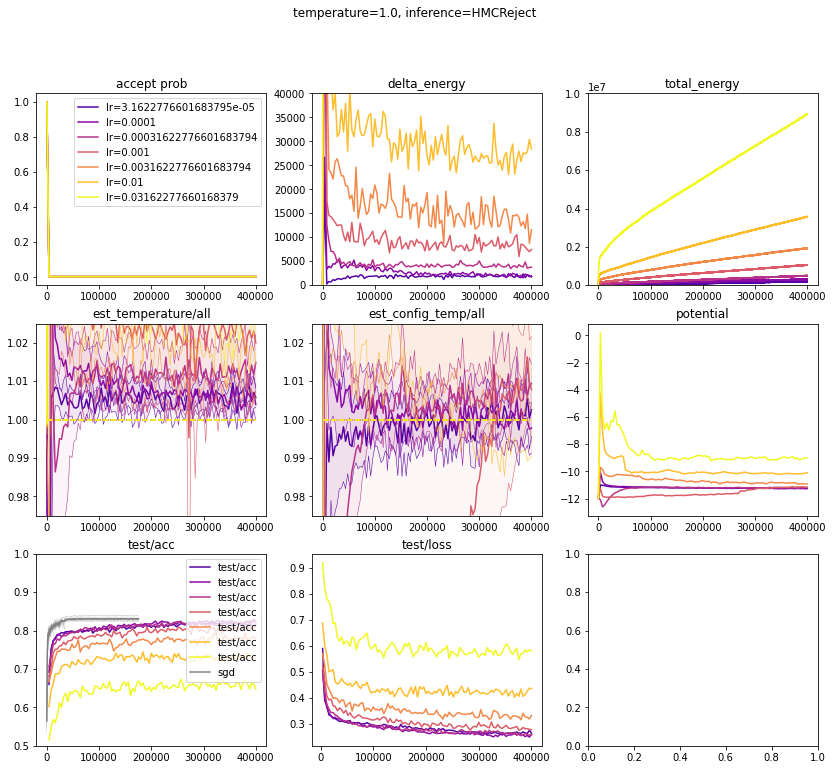

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(14, 12), facecolor='white')


inference = "HMCReject"
temperature = 1.0

def accept_prob(x):
    return np.exp(np.minimum(0., -x/temperature))


completed_df = full_df[(full_df["weight_prior"] == "gaussian") 
                       & (full_df["temperature"] == temperature)
                       & (full_df["inference"] == inference)
                       & (full_df["lr"] != 0.1)]

cmap = plt.get_cmap('plasma')

fig.suptitle(f"temperature={temperature}, inference={inference}")
for i_order, idx in enumerate(completed_df.sort_values("lr").index):

    color_kwargs = dict(color=cmap((i_order+1) / len(completed_df)))
    plot_kwargs = dict(label=f"lr={completed_df.loc[idx, 'lr']}", **color_kwargs)
    
    with h5py.File(Path(completed_df.loc[idx, "the_dir"], "metrics.h5"), "r", swmr=True) as metrics:
        is_sample_mask = (metrics['acceptance/is_sample'][:] == 1)
        ax = axes[0, 0]
        plot.metric(ax, metrics, "delta_energy", transform=accept_prob,
                    plot_kwargs=plot_kwargs, mask=is_sample_mask)
        ax.set_title("accept prob")

        ax = axes[0, 1]
        plot.metric(ax, metrics, "delta_energy", mask=is_sample_mask, ewma_alpha=0.0, iqr_ylim=None,
                   plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("delta_energy")

        #plot.vlines(axes[1], metrics, is_sample_mask)
        ax = axes[0, 2]
        plot.metric(ax, metrics, "total_energy", mask=slice(None), iqr_ylim=None, plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("total_energy")
        
        ax = axes[1, 0]
        plot.temperature_stderr(ax, metrics, "est_temperature", sizes, mask=is_sample_mask, legend=False,
                                line_kwargs=color_kwargs)
        ax.set_title("est_temperature/all")
        
        ax = axes[1, 1]
        plot.temperature_stderr(ax, metrics, "est_config_temp", sizes, mask=is_sample_mask, legend=False,
                                line_kwargs=color_kwargs)
        ax.set_title("est_config_temp/all")
        
        
        ax = axes[1, 2]
        plot.metric(ax, metrics, "potential", mask=is_sample_mask, plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("potential")
        
        ax = axes[2, 0]
        plot.metric(ax, metrics, "test/acc", mask=is_sample_mask, plot_kwargs=color_kwargs, legend=False)
        ax.set_title("test/acc")
        
        ax = axes[2, 1]
        plot.metric(ax, metrics, "test/loss", mask=is_sample_mask, plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("test/loss")

        
axes[2, 0].plot(steps*(50000/128), np.mean(test_accs, 0), color="grey", label="sgd")
for ta in test_accs:
    axes[2, 0].plot(steps*(50000/128), ta, color="grey", linewidth=0.1)
axes[2, 0].legend()

        
axes[0, 1].set_ylim(-10, 40000)
axes[0, 2].set_ylim(-10, 10000000)
if temperature == 1.0:
    axes[1, 0].set_ylim(0.975, 1.025)
    axes[1, 1].set_ylim(0.975, 1.025)
elif temperature == 0.01:
    axes[1, 0].set_ylim(0.005, 0.02)
    axes[1, 1].set_ylim(0.004, 0.02)
axes[2, 0].set_ylim((0.5, 1.0))

In [24]:
full_df["the_dir"].apply()

0      True
2      True
3      True
4      True
6      True
7      True
9      True
12     True
13     True
14     True
15     True
19     True
21     True
22     True
23     True
24     True
25     True
26    False
27     True
28     True
31     True
36    False
39     True
40     True
41     True
42     True
44     True
51     True
52     True
53     True
54     True
55     True
56     True
58    False
59     True
60     True
Name: the_dir, dtype: bool

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


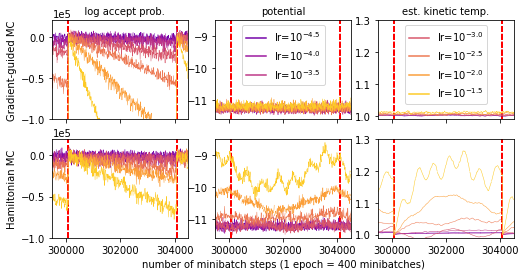

In [74]:
fig, all_axes = plt.subplots(2, 3, figsize=(8.27, 4), facecolor='white')

import matplotlib
labelsize= matplotlib.rcParams['axes.labelsize']

def log_accept_prob(x):
    return -x/temperature

def metrics_exist(the_dir):
    return os.path.exists(os.path.join(the_dir, "metrics.h5"))

inference = "VerletSGLDReject"
temperature = 1.0
#fig.suptitle(f"Preresnet18, on CIFAR-10 with data augmentation")


completed_df = full_df[(full_df["weight_prior"] == "gaussian") 
                       & (full_df["temperature"] == temperature)
                       & (full_df["inference"] == inference)
                       & (full_df["lr"] != 0.1)
                       & (full_df["the_dir"].apply(metrics_exist))]

min_log_lr = math.log(full_df["lr"].min(), 10) - 1
max_log_lr = math.log(full_df["lr"].max(), 10)
_cmap = plt.get_cmap('plasma')

def lr_cmap(log_lr):
    x = (log_lr - min_log_lr) / (max_log_lr- min_log_lr)
    return _cmap(x)
    


axes = all_axes[0]
for i_order, idx in enumerate(completed_df.sort_values("lr").index):
    log_lr = round(math.log(completed_df.loc[idx, 'lr'], 10)*10) / 10
    
    color_kwargs = dict(color=lr_cmap(log_lr), alpha=1)
    #color_kwargs = dict(color="C1", alpha=1)
    plot_kwargs = dict(**color_kwargs, label=None, linewidth=0.5)
    label=f"lr=$10^{{{log_lr}}}$"
    
    with h5py.File(Path(completed_df.loc[idx, "the_dir"], "metrics.h5"), "r", swmr=True) as metrics:
        is_sample_mask = (metrics['acceptance/is_sample'][:] == 1)
        #is_sample_mask = slice(None)
        ax = axes[0]
        plot.metric(ax, metrics, "delta_energy", transform=log_accept_prob,
                    plot_kwargs=plot_kwargs, mask=slice(None), legend=False)
        ax.set_title("   log accept prob.", fontsize=labelsize)
        plot.vlines(ax, metrics, is_sample_mask)
        
        ax = axes[1]
        plot.metric(ax, metrics, "potential", mask=slice(None), plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("potential", fontsize=labelsize)
        plot.vlines(ax, metrics, is_sample_mask)
        if i_order < 3:
            ax.plot([], [], **color_kwargs, label=label)
        ax.legend(loc='upper center')
        
        ax = axes[2]
        plot.metric(ax, metrics, "est_temperature/all", mask=slice(None), plot_kwargs=plot_kwargs, legend=False)
        ax.set_title("est. kinetic temp.", fontsize=labelsize)
        plot.vlines(ax, metrics, is_sample_mask)
        if i_order >= 3:
            ax.plot([], [], **color_kwargs, label=label)
        ax.legend(loc='upper center')
            
axes[0].set_ylabel("Gradient-guided MC")

        
inference = "HMCReject"
temperature = 1.0
cmap = plt.get_cmap('plasma')

completed_df = full_df[(full_df["weight_prior"] == "gaussian") 
                       & (full_df["temperature"] == temperature)
                       & (full_df["inference"] == inference)
                       & (full_df["lr"] != 0.1)
                       & (full_df["the_dir"].apply(metrics_exist))]

axes = all_axes[1]
for i_order, idx in enumerate(completed_df.sort_values("lr").index):
    log_lr = round(math.log(completed_df.loc[idx, 'lr'], 10)*10) / 10
    
    color_kwargs = dict(color=lr_cmap(log_lr), alpha=1)
    #color_kwargs = dict(color="C1", alpha=1)
    plot_kwargs = dict(label=f"$\\log_{{10}}$ lr$={{{log_lr}}}$", **color_kwargs, linewidth=0.5)
    
    with h5py.File(Path(completed_df.loc[idx, "the_dir"], "metrics.h5"), "r", swmr=True) as metrics:
        is_sample_mask = (metrics['acceptance/is_sample'][:] == 1)
        #is_sample_mask = slice(None)
        ax = axes[0]
        plot.metric(ax, metrics, "delta_energy", transform=log_accept_prob,
                    plot_kwargs=plot_kwargs, mask=slice(None), legend=False)
        #ax.set_title("log accept prob.")
        plot.vlines(ax, metrics, is_sample_mask)
        
        ax = axes[1]
        plot.metric(ax, metrics, "potential", mask=slice(None), plot_kwargs=plot_kwargs, legend=False)
        #ax.set_title("potential")
        plot.vlines(ax, metrics, is_sample_mask)
        
        ax = axes[2]
        plot.metric(ax, metrics, "est_temperature/all", mask=slice(None), plot_kwargs=plot_kwargs, legend=False)
        #ax.set_title("est_temperature/all")
        plot.vlines(ax, metrics, is_sample_mask)
axes[0].set_ylabel("Hamiltonian MC")

for ax in all_axes[0]:
    ax.set(xticklabels=[])

for axes in all_axes:
    axes[0].set_ylim((-100000, 20000))
    axes[0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    axes[0].set_xlim((299500, 304500))
    axes[1].set_ylim((-11.6, -8.5))
    axes[1].set_xlim((299500, 304500))
    axes[2].set_ylim((0.99, 1.3))
    axes[2].set_xlim((299500, 304500))
    
all_axes[1, 1].set_xlabel("number of minibatch steps (1 epoch = 400 minibatches)")
fig.savefig("../figures/mcmc/accept_prob_preresnet18_cifar10.pdf", bbox_inches='tight')